# Audi Project Análisis económico

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Parametros 
costo_almacenamiento_por_unidad_por_año = 2  # USD
horizonte_tiempo_años = 1

In [3]:
warehouse=pd.read_excel('Warehouse_detail_Excel.xlsx')

In [4]:
warehouse.head()

,SLoc,Typ,Stor. Bin,Material,Material Description,MRPCn,Name,S,Storage Unit,PackMatls,...,WUn,Length,Height,Width,Unit of Dimension,per,MovAvgPrice,SLED/BBD,GR Date,Last mvt
0,S040,422,KR04N01E,SCKAA08001A,"MigWeld CuSi3 0,8mm",C26,Kevin Castillo,NaN,96316000100641,A153727,...,KG,1130.0,637.0,747.0,MM,100.0,990.34,NaT,2016-04-21,2023-04-16
1,S040,422,KR04N01H,SCKAA08001A,"MigWeld CuSi3 0,8mm",C26,Kevin Castillo,NaN,96316000100643,A153727,...,KG,1130.0,637.0,747.0,MM,100.0,990.34,NaT,2016-04-21,2023-04-16
2,S040,422,KR04N02H,SCKAA08001A,"MigWeld CuSi3 0,8mm",C26,Kevin Castillo,NaN,96316000200811,A153728,...,KG,1130.0,425.0,747.0,MM,100.0,990.34,NaT,2016-05-26,2023-04-16
3,S040,422,KR04N01F,SCKAA08001A,"MigWeld CuSi3 0,8mm",C26,Kevin Castillo,NaN,96316000200826,A153727,...,KG,1130.0,637.0,747.0,MM,100.0,990.34,NaT,2016-05-26,2023-04-16
4,S001,748,JIS10A005A,4M0199869AN,SUPPORT BEARING,C41,Andrea Arenas,NaN,96316000214819,562013,...,KG,1200.0,165.0,1000.0,MM,100.0,414.46,NaT,2015-10-16,2022-12-17


In [5]:
precios=pd.read_excel('preciou_audi_excel.xlsx')

In [7]:
precios.head()

,Material,Descripción,Source,MRPCn,Disponent,Price / Unit,Bedarf
0,03G145291,CAP,C,C83,Dulce Ortega,41.9625,5024
1,03L130118,TUNED MASS DAMPER,C,C43,Andrea Arenas,0.0750,9056
2,04L103164,KUGELBOLZEN,C,C83,Dulce Ortega,0.1316,1
3,04L129661E,INTAKE MANIFOLD,M,M23,Ivan Sanchez,4.4838,23516
4,04L253725C,CLIP,C,C83,Dulce Ortega,1.0928,74


In [6]:
combined_data= pd.merge(warehouse, precios, on='Material', how='inner')

In [8]:
# Calcular los días desde el último movimiento
combined_data['Last mvt'] = pd.to_datetime(combined_data['Last mvt'], errors='coerce')
combined_data['Days Since Last Mvt'] = (pd.to_datetime('today') - combined_data['Last mvt']).dt.days

In [9]:
combined_data['Total stock'].fillna(0, inplace=True)
#combined_data['Planned qty'].fillna(0, inplace=True)
combined_data['Days Since Last Mvt'].fillna(combined_data['Days Since Last Mvt'].max(), inplace=True)
combined_data['Price / Unit'].fillna(0, inplace=True)

In [16]:
# Definir criterios para low runners
# Criterio 1: Días desde el último movimiento mayor a un umbral (ejemplo: 365 días)
# Criterio 2: Stock total significativamente mayor que la demanda planificada

low_runner_criteria_days =  365 # Por ejemplo, piezas sin movimiento en los últimos 365 días
#low_runner_criteria_stock = 2  # Por ejemplo, stock total al menos 2 veces mayor que la demanda planificada

low_runners_filtered = combined_data[
    (combined_data['Days Since Last Mvt'] >= low_runner_criteria_days) 
]
   # (combined_data['Total stock'] > low_runner_criteria_stock * combined_data['Planned qty'])



#low_runners_filtered = low_runners[low_runners['Days Since Last Mvt'] >= low_runner_criteria_days]

In [17]:
#print("\nLow Runners Identificados:")
#print(low_runners_filtered[['Material','Price / Unit','Total stock','Planned qty','Days Since Last Mvt']])
#avance propuesta
low_runners_filtered = low_runners_filtered.groupby('Material').agg({
    'Price / Unit': 'first',  # Usamos 'first' porque el precio unitario debe ser el mismo para el mismo material
    'Total stock': 'sum',
    #'Planned qty': 'sum',
    'Days Since Last Mvt': 'sum'  # Sumamos los días sin movimiento
}).reset_index()

# Mostrar el resultado
print("\nLow Runners Identificados:")
print(low_runners_filtered[['Material', 'Price / Unit' ,'Total stock', 'Days Since Last Mvt']])


Low Runners Identificados:
          Material  Price / Unit  Total stock  Days Since Last Mvt
0       04L103164A        0.3008       2450.0                 5593
1      04L121065CF        1.4384       1755.0                 5395
2       04L260849C        1.7832        472.0                 3136
3       059121445L        1.0193         48.0                  479
4      059121512AM        2.2750        360.0                 4143
..             ...           ...          ...                  ...
88     SCKAA08001A        9.9034       1440.0                 7809
89  TTT800345C GRU        5.9653         53.0                22843
90       WHT003361        0.0209      37206.0                 1930
91       WHT007154        0.0050         18.0                  436
92     XXX64EVB023        0.9027       9419.0                  553

[93 rows x 4 columns]


# Escenario 1 Base

In [18]:
material_total=combined_data['Material'].nunique()
print(f"Stock total: {material_total:,.2f}")

Stock total: 3,702.00


In [19]:
#calcular el precio total del inventerio
precio_inventario = combined_data['Total stock']*combined_data['Price / Unit']
precio_total= precio_inventario.sum()
stock_total= combined_data['Total stock'].sum()
print(f"Precio total de todo el inventario:${precio_total:,.2f}")
print(f"Stock total: {stock_total:,.2f}")

Precio total de todo el inventario:$77,239,298.03
Stock total: 44,107,613.20


In [20]:
Low_runners_material_total=low_runners_filtered['Material'].count()
print(f"Stock total: {Low_runners_material_total:,.2f}")

Stock total: 93.00


In [21]:
#Calcular el precio total de los low Runners
precio_lowrunners= low_runners_filtered['Total stock'] * low_runners_filtered['Price / Unit']
precio_total_lr=precio_lowrunners.sum()
lr_total= low_runners_filtered['Total stock'].sum()
print(f"Precio total de los Low Runners: ${precio_total_lr:,.2f}")
print(f"Stock total de low Runners: {lr_total:,.2f}")

Precio total de los Low Runners: $137,630.20
Stock total de low Runners: 145,981.00


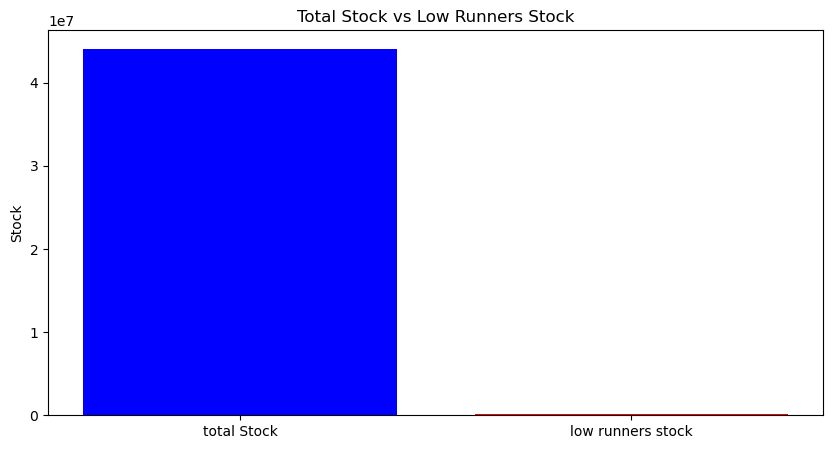

In [22]:
#gráfico representativo
labels= ['total Stock', 'low runners stock']
values= [stock_total, lr_total]

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color=['blue', 'red'])
plt.title('Total Stock vs Low Runners Stock')
plt.ylabel('Stock')
plt.show()

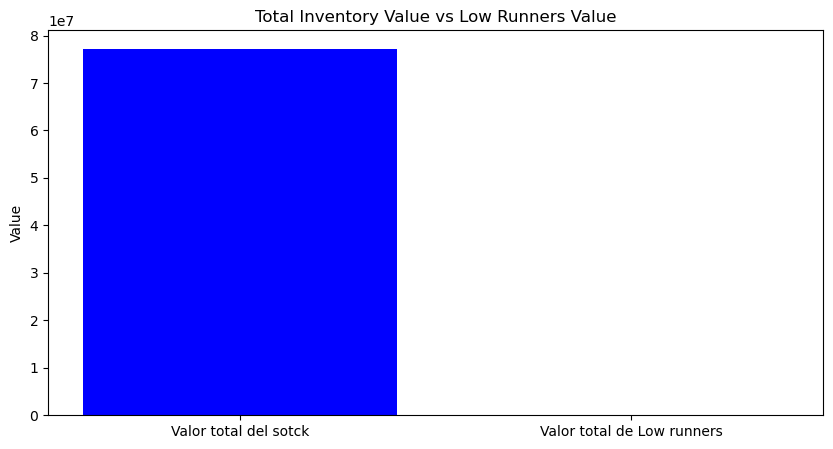

In [23]:
# Gráfico de barras para el valor total del inventario y el valor de los low runners

labels_value = ['Valor total del sotck', 'Valor total de Low runners']
values_value = [precio_total, precio_total_lr]

plt.figure(figsize=(10, 5))
plt.bar(labels_value, values_value, color=['blue', 'red'])
plt.title('Total Inventory Value vs Low Runners Value')
plt.ylabel('Value')
plt.show()

In [24]:
#Calcular el porcentaje de low runners dentro del inventario
porcentaje_low_runners_en_stock=(lr_total/stock_total)*100
procentaje_low_runners_en_dinero=(precio_total_lr/precio_total)*100

print(f"Porcentaje de low runners en inventario: {porcentaje_low_runners_en_stock:.2f}%")
print(f"Porcentaje de low runners en inventario($): {procentaje_low_runners_en_dinero:.2f}%")


Porcentaje de low runners en inventario: 0.33%
Porcentaje de low runners en inventario($): 0.18%


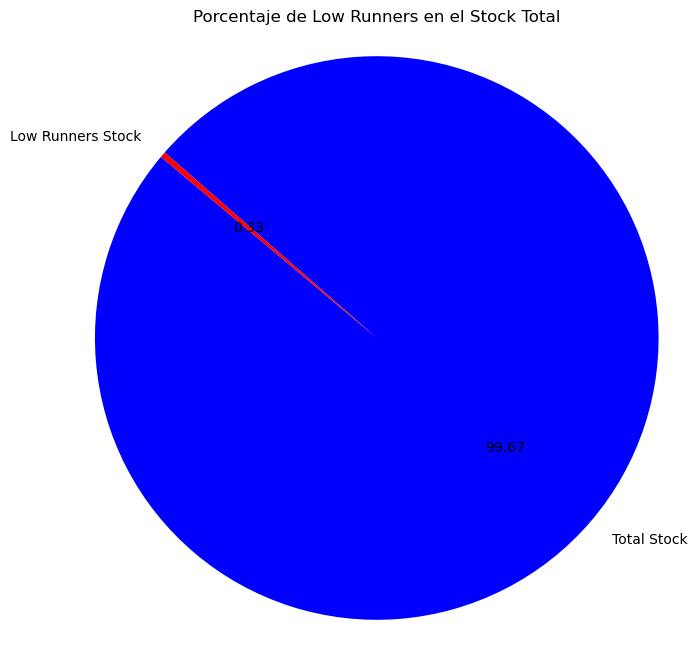

In [43]:
# Gráfico circular para el porcentaje de low runners en el stock total
labels_pie = ['Total Stock', 'Low Runners Stock']
sizes_pie = [100 - porcentaje_low_runners_en_stock, porcentaje_low_runners_en_stock ]
colors = ['blue', 'red']

plt.figure(figsize=(8, 8))
plt.pie(sizes_pie, labels=labels_pie, colors=colors, autopct='%.2f', startangle=140)
plt.axis('equal')
plt.title('Porcentaje de Low Runners en el Stock Total')
plt.show()



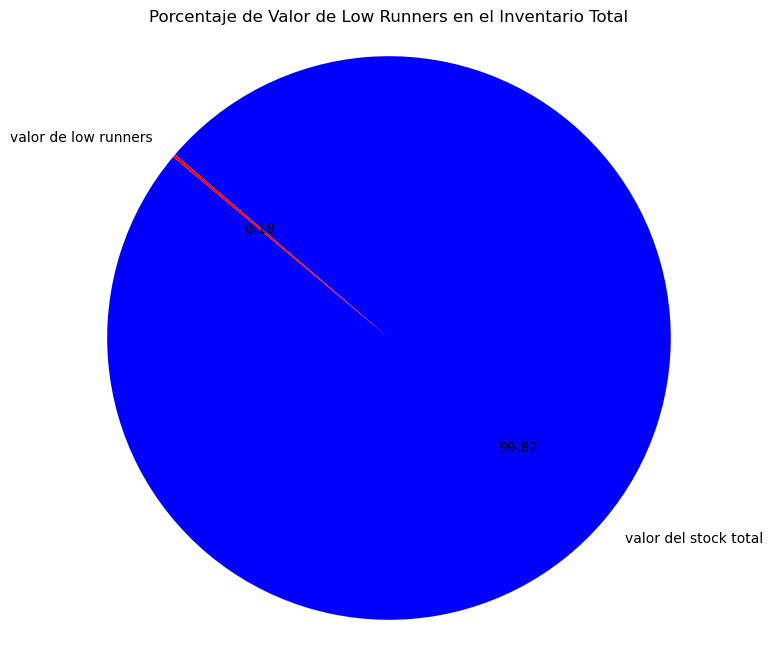

In [42]:
# Gráfico circular para el porcentaje de valor de low runners en el valor total del inventario
labels_pie_value = ['valor del stock total', 'valor de low runners']
sizes_pie_value = [100 - procentaje_low_runners_en_dinero, procentaje_low_runners_en_dinero]
colors_value = ['blue', 'red']

plt.figure(figsize=(8, 8))
plt.pie(sizes_pie_value, labels=labels_pie_value, colors=colors_value, autopct='%.2f', startangle=140)
plt.axis('equal')
plt.title('Porcentaje de Valor de Low Runners en el Inventario Total')
plt.show()

# Escenario 2: Eliminación de Low Runners

In [27]:
almacen= low_runners_filtered['Total stock']*costo_almacenamiento_por_unidad_por_año*horizonte_tiempo_años
costo_almacen=almacen.sum()
print(f'Costo de almacenar low runners : ${costo_almacen:,.2f}')

Costo de almacenar low runners : $291,962.00


In [28]:
costo_eliminar_unidad= 1 #usd

eliminar= low_runners_filtered['Total stock']*costo_eliminar_unidad
costo_eliminar= eliminar.sum()
print(f'Costo de eliminar low runners : ${costo_eliminar:,.2f}')

Costo de eliminar low runners : $145,981.00


In [29]:
dif_costo= costo_almacen - costo_eliminar
if dif_costo >= 0:
    print(f'Es mas barato eliminar los low runners, el ahorro es de : ${dif_costo:,.2f}')
else:
    print(f"Es más barato mantener los low runners. Costo adicional estimado de eliminación: ${-dif_costo:,.2f}")

Es mas barato eliminar los low runners, el ahorro es de : $145,981.00


In [30]:
# Parámetros para el análisis de sensibilidad
costo_almacenamiento_variaciones = [1, 2, 3, 4, 5]  # Variaciones en el costo de almacenamiento por unidad por año
costo_eliminacion_variaciones = [0.5, 1, 1.5, 2, 2.5]  # Variaciones en el costo de eliminación por unidad

# Realizar análisis de sensibilidad
sensibilidad_resultados = []
for almacenamiento in costo_almacenamiento_variaciones:
    for eliminacion in costo_eliminacion_variaciones:
        storage_cost = low_runners_filtered['Total stock'].sum() * almacenamiento * horizonte_tiempo_años
        elimination_cost = low_runners_filtered['Total stock'].sum() * eliminacion
        diferencia_costos = storage_cost - elimination_cost
        sensibilidad_resultados.append({
            'Costo_Almacenamiento': almacenamiento,
            'Costo_Eliminacion': eliminacion,
            'Diferencia_Costos': diferencia_costos
        })

# Mostrar los resultados del análisis de sensibilidad
sensibilidad_df = pd.DataFrame(sensibilidad_resultados)
print(sensibilidad_df)

    Costo_Almacenamiento  Costo_Eliminacion  Diferencia_Costos
0                      1                0.5            72990.5
1                      1                1.0                0.0
2                      1                1.5           -72990.5
3                      1                2.0          -145981.0
4                      1                2.5          -218971.5
5                      2                0.5           218971.5
6                      2                1.0           145981.0
7                      2                1.5            72990.5
8                      2                2.0                0.0
9                      2                2.5           -72990.5
10                     3                0.5           364952.5
11                     3                1.0           291962.0
12                     3                1.5           218971.5
13                     3                2.0           145981.0
14                     3                2.5            

# Escenario 3: Mixto


In [31]:
reduccion_factor= 0.5
low_runners_reduced = low_runners_filtered.copy()
low_runners_reduced['Total stock']=low_runners_reduced['Total stock']*reduccion_factor
#low_runners_reduced['Inventory Value'] = low_runners_reduced['Total stock'] * low_runners_reduced['Price / Unit']


In [32]:
almacen_mixto= low_runners_reduced['Total stock']*costo_almacenamiento_por_unidad_por_año*horizonte_tiempo_años
costo_almacen_mixto=almacen_mixto.sum()
print(f'Costo de almacenar low runners : ${costo_almacen_mixto:,.2f}')

Costo de almacenar low runners : $145,981.00


In [33]:
costo_eliminar_unidad= 1 #usd

eliminar_mixto=low_runners_reduced['Total stock']*costo_eliminar_unidad
costo_eliminar_mixto= eliminar_mixto.sum()
print(f'Costo de eliminar low runners : ${costo_eliminar_mixto:,.2f}')

Costo de eliminar low runners : $72,990.50


In [34]:
dif_costo_mixto= costo_almacen_mixto - costo_eliminar_mixto
if dif_costo >= 0:
    print(f'Es mas barato eliminar los low runners, el ahorro es de : ${dif_costo_mixto:,.2f}')
else:
    print(f"Es más barato mantener los low runners. Costo adicional estimado de eliminación: ${-dif_costo_mixto:,.2f}")

Es mas barato eliminar los low runners, el ahorro es de : $72,990.50


In [35]:
suma=costo_eliminar_mixto+costo_almacen_mixto
print(f'${suma:,.2f}')

$218,971.50


In [36]:
# Análisis de sensibilidad para el escenario mixto
costo_almacenamiento_variaciones_1 = [1, 2, 3, 4, 5]  # Variaciones en el costo de almacenamiento por unidad por año
costo_eliminacion_variaciones_1 = [0.5, 1, 1.5, 2, 2.5]  # Variaciones en el costo de eliminación por unidad

# Realizar análisis de sensibilidad
sensibilidad_resultados_mixto_1 = []
for almacenamiento_1 in costo_almacenamiento_variaciones_1:
    for eliminacion_1 in costo_eliminacion_variaciones_1:
        storage_cost_1 = low_runners_reduced['Total stock'].sum() * almacenamiento_1 * horizonte_tiempo_años
        elimination_cost_1 = low_runners_reduced['Total stock'].sum() * eliminacion_1
        diferencia_costos_1 = storage_cost_1 - elimination_cost_1
        sensibilidad_resultados_mixto_1.append({
            'Costo_Almacenamiento': almacenamiento_1,
            'Costo_Eliminacion': eliminacion_1,
            'Diferencia_Costos': diferencia_costos_1
        })

# Mostrar los resultados del análisis de sensibilidad
sensibilidad_df_mixto = pd.DataFrame(sensibilidad_resultados_mixto_1)
print(sensibilidad_df_mixto)

    Costo_Almacenamiento  Costo_Eliminacion  Diferencia_Costos
0                      1                0.5           36495.25
1                      1                1.0               0.00
2                      1                1.5          -36495.25
3                      1                2.0          -72990.50
4                      1                2.5         -109485.75
5                      2                0.5          109485.75
6                      2                1.0           72990.50
7                      2                1.5           36495.25
8                      2                2.0               0.00
9                      2                2.5          -36495.25
10                     3                0.5          182476.25
11                     3                1.0          145981.00
12                     3                1.5          109485.75
13                     3                2.0           72990.50
14                     3                2.5           3

     Escenario  Costo de Almacenamiento  Costo de Eliminación  Costo Total
0         Base                 291962.0                   0.0     291962.0
1  Eliminación                      0.0              145981.0     145981.0


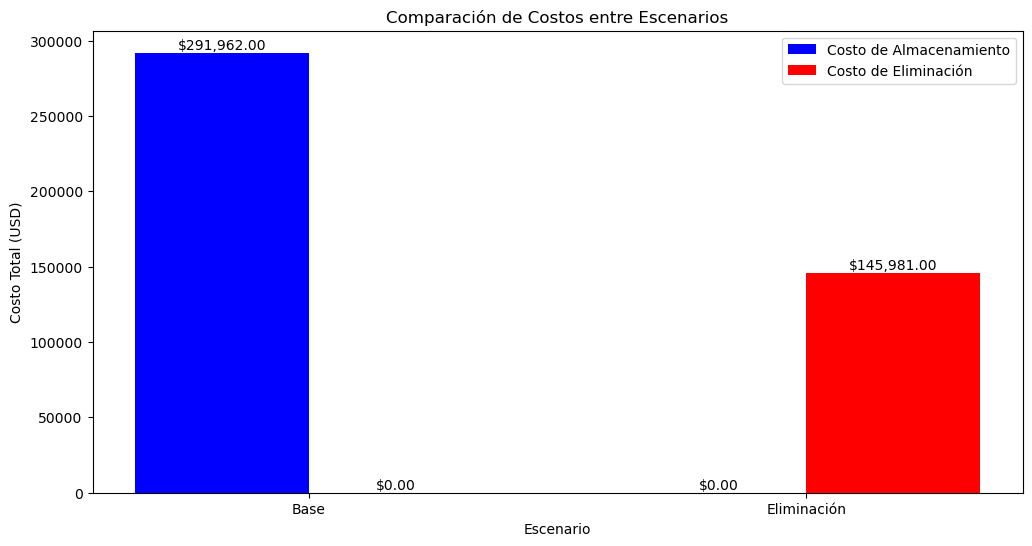

In [44]:
# Reunir los costos en un solo DataFrame
costos_escenarios = {
    'Escenario': ['Base', 'Eliminación'],
    'Costo de Almacenamiento': [costo_almacen, 0],
    'Costo de Eliminación': [0, costo_eliminar],
    'Costo Total': [costo_almacen, costo_eliminar]
}

costos_df = pd.DataFrame(costos_escenarios)
print(costos_df)

# Visualizar los resultados
fig, ax = plt.subplots(figsize=(12, 6))

# Crear barras para el costo de almacenamiento y eliminación
bar_width = 0.35
index = range(len(costos_df))

storage_bars = plt.bar(index, costos_df['Costo de Almacenamiento'], bar_width, label='Costo de Almacenamiento', color='blue')
elimination_bars = plt.bar([i + bar_width for i in index], costos_df['Costo de Eliminación'], bar_width, label='Costo de Eliminación', color='red')

# Añadir etiquetas y título
plt.xlabel('Escenario')
plt.ylabel('Costo Total (USD)')
plt.title('Comparación de Costos entre Escenarios')
plt.xticks([i + bar_width / 2 for i in index], costos_df['Escenario'])
plt.legend()

# Mostrar los valores encima de las barras
for bar in storage_bars + elimination_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'${yval:,.2f}', ha='center', va='bottom')

plt.show()

In [31]:
#low_runners_filtered.to_excel('low_runners_filtered.xlsx', index=False)

In [32]:
#combined_data.to_excel('combined_data.xlsx', index=False)

In [63]:
combined_data_new= combined_data.groupby('Material').agg({
    'Price / Unit': 'first',  # Usamos 'first' porque el precio unitario debe ser el mismo para el mismo material
    'Total stock': 'sum',
    #'Planned qty': 'sum',
    #'Days Since Last Mvt': 'sum'  # Sumamos los días sin movimiento
}).reset_index()

# Mostrar el resultado
print("\nWareHouse:")
print(combined_data_new[['Material','Price / Unit', 'Total stock']])


WareHouse:
               Material  Price / Unit  Total stock
0            03G906051M        3.2765       5700.0
1             03L130118        0.0750       2500.0
2             03L260817        0.0382      15500.0
3     04L100018GBS 4623     3642.0415         38.0
4             04L103164        0.1316        100.0
...                 ...           ...          ...
3697          WHT008843        0.0483     227400.0
3698          WHT008954        0.3145      11700.0
3699         WHT009012B        0.2933     116200.0
3700          WHT009581        0.0660     101800.0
3701        XXX64EVB023        0.9027       9419.0

[3702 rows x 3 columns]


In [64]:
combined_data_new.to_excel('combined_data_new.xlsx', index=False)